# Import relevant modules and data

In [1]:
# Import relevant modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
import optuna
import pickle
from sklearn.feature_selection import RFE

/Users/clarerigby/anaconda3/envs/fiverr_imtyjb_banks/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load modified & cleaned personal loan data into a Pandas DataFrame
df_loan_data = pd.read_pickle('df_loan_data.pkl')

# Transform data to suit the LGBM algorithm

SVC models require scaled data. The data used here is pre-scaled from the data_preparation notebook.

SVC models perform better with balanced classes (and this data has reasonably strong imbalance). This re-balancing will be handled via SMOTE techniques within model training

# Perform RFA to determine the ideal feature set for this model
Note this time we are doing feature addition instead of elimination, as this works better for SVC models

In [3]:
# Load tuned best parameters from full-feature model
with open('SVC_best_params.pkl', 'rb') as file:
    params = pickle.load(file)

In [4]:
# Define the target variable
target_variable = 'personal_loan'

In [5]:
# Separate features and target variable
X = df_loan_data.drop(columns=[target_variable])
y = df_loan_data[target_variable]

In [6]:
# Set up cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [7]:
# Initialize RFA
rfe = RFE(SVC(C=params['C'], kernel=params['kernel'], probability=True))

In [8]:
# Lists to store results
num_features_list = []
mean_AUC_list = [] 

In [9]:
# Define a custom function for evaluating AUC
def evaluate_auc(X_train, y_train, X_valid, y_valid):
    model = SVC(C=params['C'], kernel=params['kernel'], probability=True)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, y_pred)

In [10]:
# Loop through the feature elimination process
for feature_idx in range(len(X.columns)):
    rfe.n_features_to_select = feature_idx + 1
    rfe.fit(X, y)
    selected_features = rfe.support_
    features_to_use = [i for i, select in enumerate(selected_features) if select]

    auc_scores_fold = []  # AUC values for the current fold

    for train_index, valid_index in skf.split(X, y):
        X_train, X_valid = X.iloc[train_index, features_to_use], X.iloc[valid_index, features_to_use]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        # Apply SMOTE for class balancing
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

        # Evaluate model performance with AUC
        auc = evaluate_auc(X_train_resampled, y_train_resampled, X_valid, y_valid)
        auc_scores_fold.append(auc)

    # Calculate the mean AUC for the current number of features
    mean_AUC = np.mean(auc_scores_fold)
    num_features_list.append(feature_idx + 1)
    mean_AUC_list.append(mean_AUC)

    # Store the best AUC for the fold
    best_auc_fold = max(auc_scores_fold)
    print('Number of Features: {}, Best AUC: {}'.format(feature_idx + 1, best_auc_fold))

Number of Features: 1, Best AUC: 0.921440009854644
Number of Features: 2, Best AUC: 0.9347776545947277
Number of Features: 3, Best AUC: 0.9441580438531658
Number of Features: 4, Best AUC: 0.9449371766444937
Number of Features: 5, Best AUC: 0.9498706577974869
Number of Features: 6, Best AUC: 0.9508468834688347
Number of Features: 7, Best AUC: 0.9518877802414388
Number of Features: 8, Best AUC: 0.9527100271002711


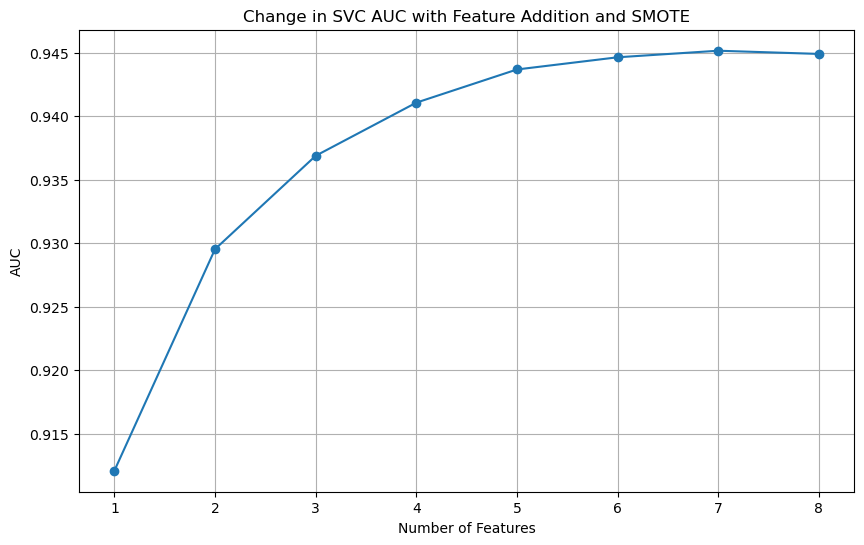

In [11]:
# Plot the change in AUC as features are added
plt.figure(figsize=(10, 6))
plt.plot(num_features_list, mean_AUC_list, marker='o')
plt.title('Change in SVC AUC with Feature Addition and SMOTE')
plt.xlabel('Number of Features')
plt.ylabel('AUC')
plt.grid(True)
plt.show()

In [12]:
# Based on the SVC RFA analysis, we should keep the following 5 features
rfe.n_features_to_select = 5
rfe.fit(X, y)
selected_feats = X.columns[rfe.support_]
print(selected_feats)

Index(['family_size', 'education_level', 'income', 'fixed_deposit_acct',
       'fin_exposure'],
      dtype='object')


# Optimize the model with reduced features

In [13]:
# Implement feature reduction
df_loan_data = df_loan_data.loc[:, list(selected_feats) + [target_variable]]

In [14]:
# Separate features and target variable
X = df_loan_data.drop(columns=[target_variable])
y = df_loan_data[target_variable]

In [15]:
# Set up cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [25]:
# Define the objective function for Optuna
def objective(trial):

    # Only tune regularization parameter here, otherwise siginficantly change model type
    C = trial.suggest_float('C', 0.01, 10, log=True)  

    auc_scores = []

    # Perform cross-validation
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Apply SMOTE for class balancing
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

        # Create and train the SVM model
        model = SVC(C=C, kernel='linear', probability=True)
        model.fit(X_train_resampled, y_train_resampled)

        # Make predictions
        y_pred = model.predict_proba(X_test)[:, 1]

        # Calculate ROC AUC score
        auc = roc_auc_score(y_test, y_pred)
        auc_scores.append(auc)

    # Calculate the mean AUC score across cross-validation folds
    mean_auc = np.mean(auc_scores)
    return mean_auc

In [26]:
# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2023-10-13 23:59:43,810] A new study created in memory with name: no-name-ff77b07c-355b-4bdd-a4df-5ef2a623e17b
[I 2023-10-13 23:59:49,611] Trial 0 finished with value: 0.9430567873860557 and parameters: {'C': 6.031465137197945}. Best is trial 0 with value: 0.9430567873860557.
[I 2023-10-13 23:59:54,918] Trial 1 finished with value: 0.9430857354028086 and parameters: {'C': 1.3507838172349835}. Best is trial 1 with value: 0.9430857354028086.
[I 2023-10-14 00:00:01,091] Trial 2 finished with value: 0.9433881497905888 and parameters: {'C': 0.21597063491686586}. Best is trial 2 with value: 0.9433881497905888.
[I 2023-10-14 00:00:06,485] Trial 3 finished with value: 0.9431233062330623 and parameters: {'C': 0.8602893785918}. Best is trial 2 with value: 0.9433881497905888.
[I 2023-10-14 00:00:11,874] Trial 4 finished with value: 0.9430955900468095 and parameters: {'C': 1.2346896868498682}. Best is trial 2 with value: 0.9433881497905888.
[I 2023-10-14 00:00:19,908] Trial 5 finished with valu

In [29]:
mean_auc

0.8720485341217049

In [18]:
# Get the best hyperparameters
best_params = study.best_params
print('Best Hyperparameters: {}'.format(best_params))

Best Hyperparameters: {'C': 0.18371352210091244}


In [19]:
# Save the finalized best params
with open('SVC_reduced_best_params.pkl', 'wb') as file:
    pickle.dump(best_params, file)

# Train and evaluate a model using the best hyperparameters

In [43]:
# Initialize lists to store results from best model
auc_scores = []

In [44]:
# Perform cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply SMOTE to oversample the minority class
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Initialize the SVM model (Support Vector Classifier)
    svm_model = SVC(probability=True, C=best_params['C'], kernel='linear')

    # Fit the SVM model
    svm_model.fit(X_train_resampled, y_train_resampled)

    # Make predictions
    y_pred = svm_model.predict_proba(X_test)[:, 1]

    # Calculate ROC AUC score
    auc = roc_auc_score(y_test, y_pred)
    auc_scores.append(auc)

In [45]:
# Calculate the mean AUC score across cross-validation folds
mean_auc = np.mean(auc_scores)
print('Mean AUC: {}'.format(mean_auc))

Mean AUC: 0.9434830007390984
